In [1]:

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def connected_triangles_adj_matrix(n):
    """
    Generate the adjacency matrix for 'n' connected triangles in a chain.
    """
    num_nodes = 2 * n + 1
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
 
    for i in range(n):
        a, b, c = i * 2, i * 2 + 1, i * 2 + 2  # Nodes of the current triangle
 
        # Connect the three nodes in a triangle
        adj_matrix[a, b] = adj_matrix[b, a] = 1
        adj_matrix[b, c] = adj_matrix[c, b] = 1
        adj_matrix[a, c] = adj_matrix[c, a] = 1
 
        # If not the first triangle, connect to the previous triangle
        if i > 0:
            adj_matrix[a, a - 1] = adj_matrix[a - 1, a] = 1
            adj_matrix[b, b - 2] = adj_matrix[b - 2, b] = 1
 
    return adj_matrix

def nn_adj_matrix(n):
    """
    Generate the adjacency matrix for 'n' connected triangles in a chain.
    """
    num_nodes = 2 * n + 1
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
 
    for i in range(n):
        a, b, c = i * 2, i * 2 + 1, i * 2 + 2  # Nodes of the current triangle
 
        # Connect the three nodes in a triangle
        adj_matrix[a, b] = adj_matrix[b, a] = 1
        adj_matrix[b, c] = adj_matrix[c, b] = 1
      
 
        # If not the first triangle, connect to the previous triangle
        if i > 0:
            adj_matrix[a, a - 1] = adj_matrix[a - 1, a] = 1
            
 
    return adj_matrix

In [3]:
def plot_triangle_chain(n, side=1.0):
    """
    Plot a horizontal chain of n equilateral triangles.
    Baseline: even nodes (0,2,4,...,2n) on y=0
    Apexes: odd nodes (1,3,5,...,2n-1) above the midpoint.
    """
    # Build graph
    A = connected_triangles_adj_matrix(n)
    G = nx.from_numpy_array(A)
 
    h = np.sqrt(3) / 2 * side
    pos = {}
 
    # Place baseline nodes
    for k in range(n + 1):
        pos[2 * k] = (k * side, 0.0)
 
    # Place apex nodes
    for k in range(n):
        x_left = pos[2 * k][0]
        x_right = pos[2 * k + 2][0]
        pos[2 * k + 1] = ((x_left + x_right) / 2, h)
 
    # Draw
    fig, ax = plt.subplots(figsize=(1.5 * n, 2.5))
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        font_size=10,
        font_color="white",
        node_size=600,
        node_color='blue',
        edge_color="black",
        width=2,
    )
    ax.set_aspect("equal")
    ax.margins(0.2)
    plt.show()
 
    return G, pos

In [4]:
def plot_nn_chain(n, side=1.0):
    """
    Plot a horizontal chain of n equilateral triangles.
    Baseline: even nodes (0,2,4,...,2n) on y=0
    Apexes: odd nodes (1,3,5,...,2n-1) above the midpoint.
    """
    # Build graph
    A = nn_adj_matrix(n)
    G = nx.from_numpy_array(A)
 
    h = np.sqrt(3) / 2 * side
    pos = {}
 
    # Place baseline nodes
    for k in range(n + 1):
        pos[2 * k] = (k * side, 0.0)
 
    # Place apex nodes
    for k in range(n):
        x_left = pos[2 * k][0]
        x_right = pos[2 * k + 2][0]
        pos[2 * k + 1] = ((x_left + x_right) / 2, h)
 
    # Draw
    fig, ax = plt.subplots(figsize=(1.5 * n, 2.5))
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        font_size=10,
        font_color="white",
        node_size=600,
        node_color='blue',
        edge_color="black",
        width=2,
    )
    ax.set_aspect("equal")
    ax.margins(0.2)
    plt.show()
 
    return G, pos

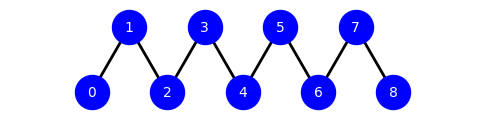

In [5]:
n_triangles = 4
n_qubits = 2 * n_triangles + 1
plot_nn_chain(n_triangles, side=1.0)
plt.show()

In [6]:
def edge_coloring(graph):
    """
    Takes a NetworkX graph and returns a list of lists where each inner list contains
    the edges assigned the same color.
    """
    line_graph = nx.line_graph(graph)
    edge_colors = nx.coloring.greedy_color(line_graph,strategy='connected_sequential')
 
    color_groups = {}
    for edge, color in edge_colors.items():
        if color not in color_groups:
            color_groups[color] = []
        color_groups[color].append(edge)
 
    return list(color_groups.values())

In [7]:
A = connected_triangles_adj_matrix(n_triangles)
A = nn_adj_matrix(n_triangles)
G = nx.from_numpy_array(A)

ec = edge_coloring(G)

## Step 2: Optimize problem for quantum hardware execution

#### Generate Trotterized circuits on spin graphs

To simulate the dynamics of the TFIM, we construct circuits that approximate the time evolution operator.
$U(t) = e^{-iHt}$, where $H=J\sum_{\langle i,j\rangle}Z_i Z_j - h \sum_i X_i$.

We use a second-order Trotter decomposition:
$
e^{-iH\Delta t } \sim e^{-iH_x\Delta t/2} e^{-iH_z\Delta t}e^{-iH_x\Delta t/2}$,
$
where $H_X = -h\sum_i X_i$ and $H_Z = H=J\sum_{\langle i,j\rangle}Z_i Z_j$.

- The $H_X$ is implemented with layers of $RX$ rotations.
- The $H_Z$ term is implemented with layers of $RZZ$ gates along the edges of the interaction graph.


The angles of these gates are determined by the transverse field $h$, the coupling constant $J$,  and the time step $\Delta t$. By stacking multiple Trotter steps, we generate circuits of increasing depth that approximate the system's dynamics. The functions generate_tfim_circ_custom_graph and trotter_circuits construct a Trotterized quantum circuit from an arbitrary spin interaction graph.

In [8]:
def generate_tfim_circ_custom_graph(
    steps, h, J, dt, psi0, graph: nx.graph.Graph, meas_basis="Z", mirror=False
):
    """
    Generate a second order trotter of the form e^(a+b) ~ e^(b/2) e^a e^(b/2) for simulating a transverse field ising model:
    e^{-i H t} where the Hamiltonian H = -J \\sum_i Z_i Z_{i+1} + h \\sum_i X_i.
 
    steps: Number of trotter steps
    theta_x: Angle for layer of X rotations
    theta_zz: Angle for layer of ZZ rotations
    theta_x: Angle for second layer of X rotations
    J: Coupling between nearest neighbor spins
    h: The transverse magnetic field strength
    dt: t/total_steps
    psi0: initial state (assumed to be prepared in the computational basis).
    meas_basis: basis to measure all correlators in
 
    This is a second order trotter of the form e^(a+b) ~ e^(b/2) e^a e^(b/2)
    """
    theta_x = h * dt
    theta_zz = -2 * J * dt
    nq = graph.number_of_nodes()
    color_edges = edge_coloring(graph)
    print(color_edges)
    circ = QuantumCircuit(nq, nq)
    # Initial state, for typical cases in the computational basis
    for i, b in enumerate(psi0):
        if b == "1":
            circ.x(i)
    # Trotter steps
    for step in range(steps):
        for i in range(nq):
            circ.rx(theta_x, i)
        if mirror:
            color_edges = [sublist[::-1] for sublist in color_edges[::-1]]
        for edge_list in color_edges:
            for edge in edge_list:
                circ.cx(edge[0], edge[1])
                circ.rz(theta_zz, edge[1])
                circ.cx(edge[0], edge[1])
        for i in range(nq):
            circ.rx(theta_x, i)
 
    # some typically used basis rotations
    if meas_basis == "X":
        for b in range(nq):
            circ.h(b)
    elif meas_basis == "Y":
        for b in range(nq):
            circ.sdg(b)
            circ.h(b)
 
    for i in range(nq):
        circ.measure(i, i)
 
    return circ
 
 
def trotter_circuits(G, d_ind_tot, J, h, dt, meas_basis, mirror=True):
    """
    Generates a sequence of Trotterized circuits, each with increasing depth.
    Given a spin interaction graph and Hamiltonian parameters, it constructs
    a list of circuits with 1 to d_ind_tot Trotter steps
 
    G: Graph defining spin interactions (edges = ZZ couplings)
    d_ind_tot: Number of Trotter steps (maximum depth)
    J: Coupling between nearest neighboring spins
    h: Transverse magnetic field strength
    dt: (t / total_steps
    meas_basis: Basis to measure all correlators in
    mirror: If True, mirror the Trotter layers
    """
    qubit_count = len(G)
    circuits = []
    psi0 = "0" * qubit_count
 
    for steps in range(1, d_ind_tot + 1):
        circuits.append(
            generate_tfim_circ_custom_graph(
                steps, h, J, dt, psi0, G, meas_basis, mirror
            )
        )
    return circuits

[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]


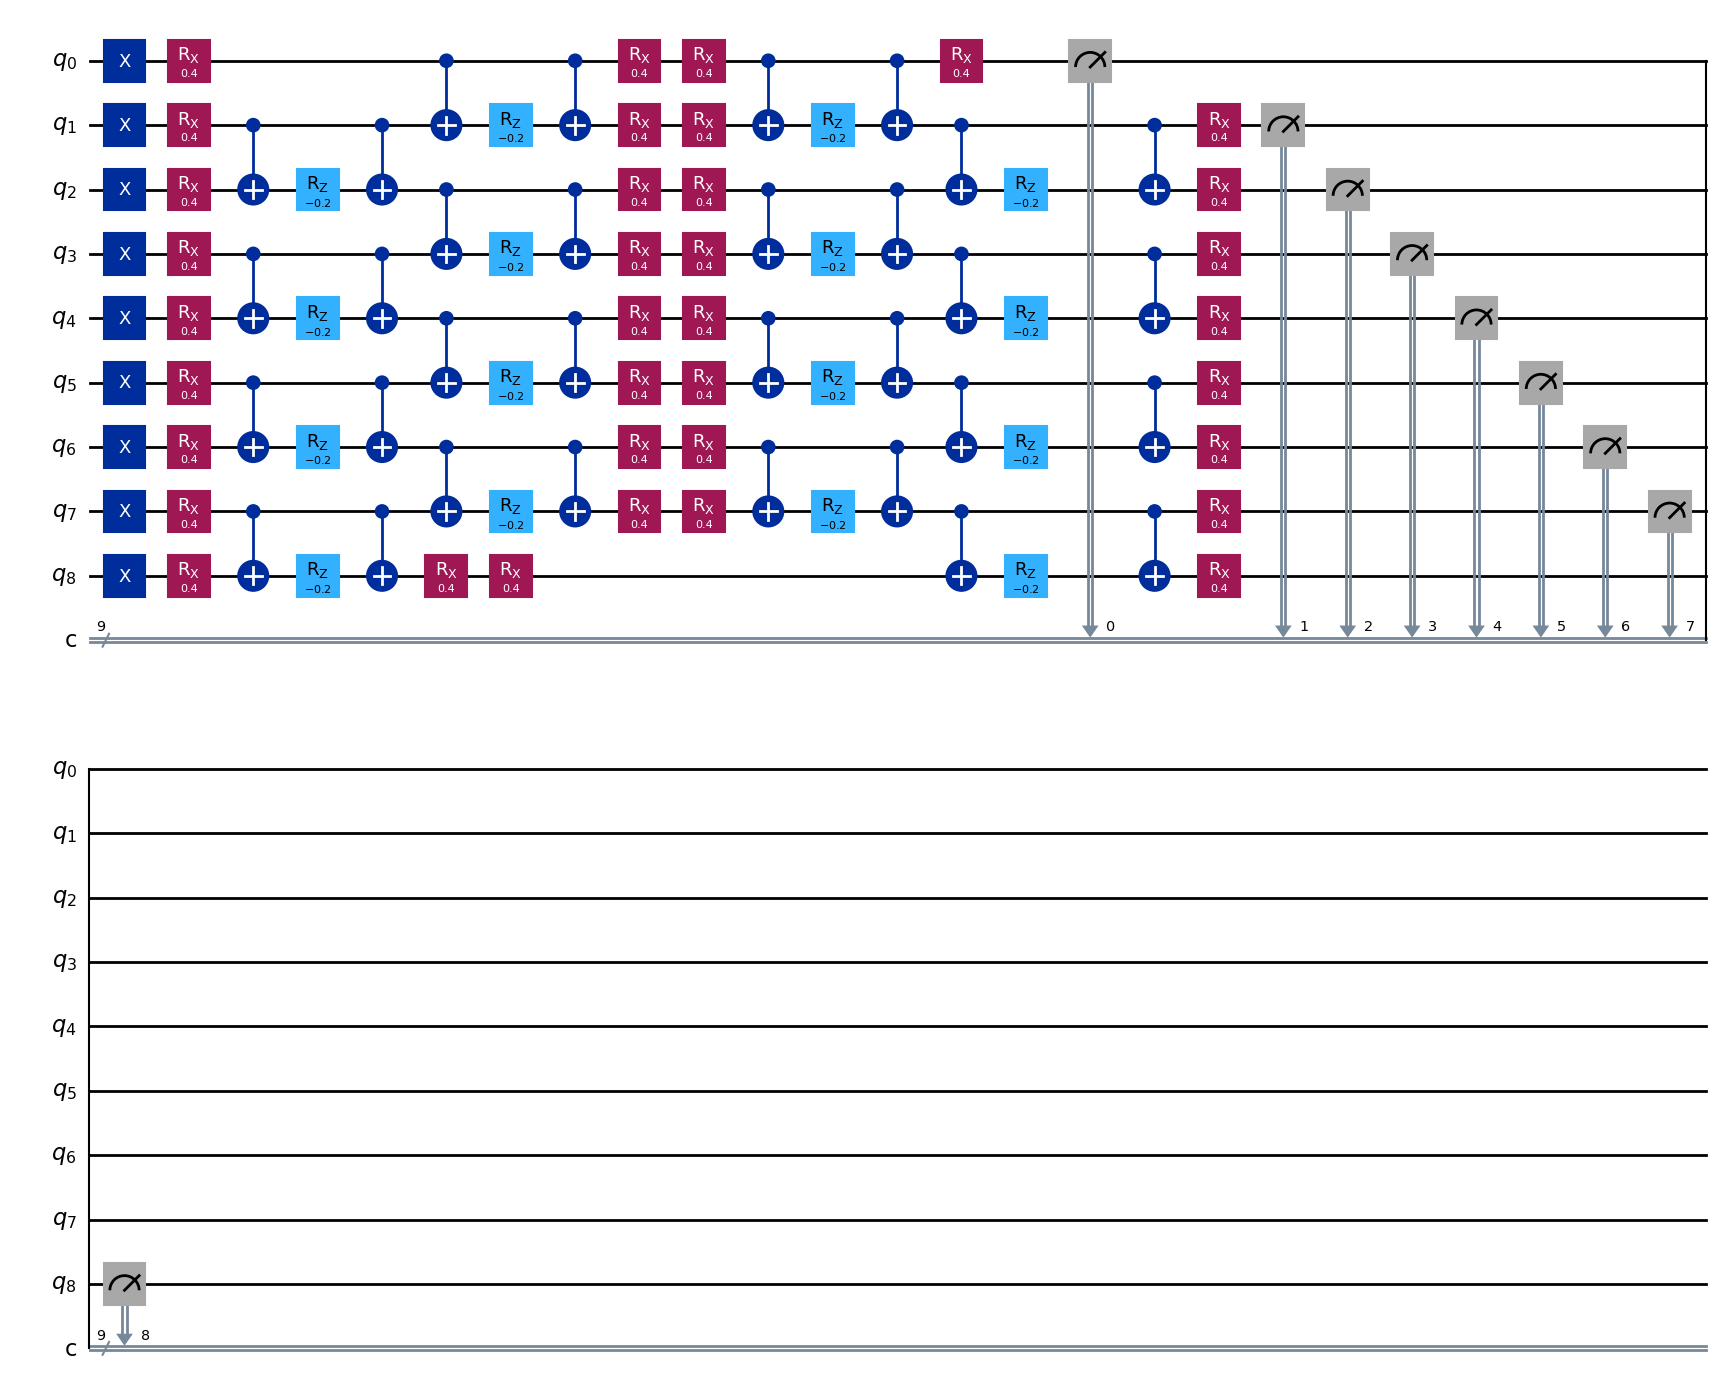

In [9]:
#draw the circuit 
n_triangles = 4
n_qubits = 2 * n_triangles + 1
A = connected_triangles_adj_matrix(n_triangles)
A = nn_adj_matrix(n_triangles)
G = nx.from_numpy_array(A)
dt= 0.1
J=1
h=4
psi0 = "1" * len(G)
cq = generate_tfim_circ_custom_graph(2,h,J,dt,psi0,G,mirror='True')
cq.draw("mpl")

#### Estimate single-qubit magnetizations $\langle Z_i \rangle$

To study the dynamics of the model, we want to measure the magnetization of each qubit, defined by the expectation value $\langle Z_i \rangle = \langle \psi|Z_i|\psi \rangle$.

In simulations, we can compute this directly from the measurement outcomes. The function z_expectation processes the bitstring counts and returns the value of $ \langle Z_i \rangle $  for a chosen qubit index.


In [10]:
def z_expectation(counts, index):
    """
    counts: Dict of mitigated bitstrings.
    index: Index i in the single operator expectation value < II...Z_i...I > to be calculated.
    return:  < Z_i >
    """
    z_exp = 0
    tot = 0
    for bitstring, value in counts.items():
        bit = int(bitstring[index])
        sign = 1
        if bit % 2 == 1:
            sign = -1
        z_exp += sign * value
        tot += value
 
    return z_exp / tot

def ising_energy(counts, J, A):
    """
    Compute the energy of an Ising model configuration.
    
    Parameters:
    -----------
    bitstring : str
        A string of '0's and '1's representing spin configuration
    J : float
        Coupling constant
    A : array-like (2D)
        Adjacency matrix defining the graph structure
    
    Returns:
    --------
    float
        The energy of the configuration
    """
    # Convert bitstring to spin values: 0 -> -1, 1 -> +1
    energy = 0.0
    tot = 0
    for bitstring, value in counts.items():
        spins = [2*int(bit) - 1 for bit in bitstring]
        n = len(spins)
    
        # Compute energy: E = -J * sum_{i,j} A_{i,j} * s_i * s_j
        ez = 0
        for i in range(n):
            for j in range(i+1, n):  # Count each pair once
                ez += J * A[i][j] * spins[i] * spins[j]
        #print('DEBUG: ', bitstring, ez)
        energy += ez*value
        tot += value
    return energy/tot



## Step 3: Execute using Qiskit primitives
#### Run MPS simulation
The list of Trotterized circuits is executed using the matrix_product_state simulator with an arbitrary choice of 4096 shots. The MPS method provides an efficient approximation of the circuit dynamics, with accuracy determined by the chosen bond dimension. For the system sizes considered here, the default bond dimension is sufficient to capture the magnetization dynamics with high fidelity. The raw counts are normalized, and from these we compute the single-qubit expectation values $\langle Z_i \rangle $ at each Trotter step. Finally, we calculate the average over all qubits to obtain a single curve that shows how the magnetization changes over time.

In [11]:
backend_sim_mps = AerSimulator(method="matrix_product_state")
backend_sim_sv = AerSimulator(method="statevector")
 
 
def normalize_counts(counts_list, shots):
    new_counts_list = []
    for counts in counts_list:
        a = {k: v / shots for k, v in counts.items()}
        new_counts_list.append(a)
    return new_counts_list
 
 
def run_sim(circ_list,backend_sim):
    shots = 4096
    res = backend_sim.run(circ_list, shots=shots)
    normed = normalize_counts(res.result().get_counts(), shots)
    return normed
 
 


In [12]:
d_ind_tot=20
circ = trotter_circuits(G, d_ind_tot, J, h, dt, "Z", True)

sim_counts = run_sim(circ,backend_sim_sv)

[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)],

In [13]:
def make_correlators(test_counts, nq, d_ind_tot):
    mz = np.empty((nq, d_ind_tot))
    for d_ind in range(d_ind_tot):
        counts = test_counts[d_ind]
        for i in range(nq):
            mz[i, d_ind] = z_expectation(counts, i)
    average_z = np.mean(mz, axis=0)
    return np.concatenate((np.array([1]), average_z), axis=0)



def make_energy(test_counts,nq,d_ind_tot,A):
    ez = np.empty( d_ind_tot)
    for d_ind in range(d_ind_tot):
        counts = test_counts[d_ind]
        ez[d_ind] = ising_energy(counts,1,A)
    return np.concatenate((np.array([A.sum()/2]), ez), axis=0)

## Step 4: Noisy Simulations
In this section we extend the ideal quantum simulation to include realistic noise effects.
Quantum hardware is affected by different types of errors, which can significantly alter the dynamics of many-body systems such as the transverse-field Ising model.
To study the robustness of the dynamics, we introduce different noise models and compare their effects. 

#### Why Noisy Simulations?

In an ideal simulator (statevector), quantum evolution is perfectly unitary:
$$
\rho(t) = U(t)\,\rho(0)\,U^\dagger(t)
$$

However, real quantum devices suffer from: Gate errors, Decoherence (T1 and T2 processes), Crosstalk, Measurement errors.
To emulate realistic hardware behavior, we use Qiskit Aer NoiseModel and simulate the circuits with a finite number of shots.

#### Bit-flip noise
Models random $X$ errors occurring during gate operations or before measurement.
Channel: $$ \rho \rightarrow (1 - p)\rho + p X \rho X $$
This type of noise primarily affects populations in the computational basis.

In [14]:
# BIT FLIP NOISE MODEL

from qiskit_aer.noise import NoiseModel, pauli_error

# Example error probabilities
p_meas = 0.0
p_gate1 = 0.01
p_cx = 0.01

# QuantumError objects
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


#### Phase-flip noise
Models $Z$ errors that destroy quantum phase coherence.
Channel: $$ \rho \rightarrow (1 - p)\rho + p Z \rho Z$$

This mainly affects superposition states and coherence in the $X/Y$ basis.

In [15]:
# PHASE FLIP NOISE MODEL

from qiskit_aer.noise import NoiseModel, pauli_error

# error probabilities
p_meas = 0.02
p_gate1 = 0.01
error_gate2 = error_gate1.tensor(error_gate1) # 2 qubits error (tensor product)

# QuantumError objects
error_meas = pauli_error([('Z', p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Z', p_gate1), ('I', 1 - p_gate1)])

# Noise model
noise_phase_flip = NoiseModel()

# measurement error
noise_phase_flip.add_all_qubit_quantum_error(error_meas, "measure")

# CX error
noise_phase_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_phase_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure', 'cx']
  All-qubits errors: ['measure', 'cx']


#### Realistic composite noise model
A more complete model including:
Depolarizing noise (random Pauli errors)
Thermal relaxation (T1 and T2 processes)
Readout error (classical measurement mistakes)
The depolarizing channel is defined as: $$\rho \rightarrow (1 - p)\rho + \frac{p}{3}\left( X \rho X + Y \rho Y + Z \rho Z \right)$$

Thermal relaxation describes energy relaxation and decoherence processes governed by the characteristic times $T_1$ and $T_2$.
Readout errors are modeled classically through a probability matrix:
$$P(measured state∣true state)$$
This composite model better approximates physical quantum hardware.

In [16]:
#DEPOLARIZING NOISE + THERMAL RELAXATION + READOUT ERROR

from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

# Parameters
p1, p2 = 0.001, 0.01      # depolarizing 1q e 2q
T1, T2 = 50e3, 70e3       # relaxation times in ns 
t1q, t2q = 50, 300        # gate durations in ns

# gates errors
err_1q = depolarizing_error(p1, 1).compose(thermal_relaxation_error(T1, T2, t1q))
err_2q = depolarizing_error(p2, 2).compose(
    thermal_relaxation_error(T1, T2, t2q).tensor(thermal_relaxation_error(T1, T2, t2q))
)

# Readout error 
p01, p10 = 0.02, 0.03
readout = ReadoutError([[1-p01, p01],
                        [p10, 1-p10]])

composed_noise = NoiseModel()
composed_noise.add_all_qubit_quantum_error(err_1q, ["rx", "ry", "rz", "sx", "x"])
composed_noise.add_all_qubit_quantum_error(err_2q, ["cx"])
composed_noise.add_all_qubit_readout_error(readout)
print(composed_noise)


NoiseModel:
  Basis gates: ['cx', 'id', 'rx', 'ry', 'rz', 'sx', 'x']
  Instructions with noise: ['ry', 'cx', 'rx', 'x', 'sx', 'measure', 'rz']
  All-qubits errors: ['rx', 'ry', 'rz', 'sx', 'x', 'cx', 'measure']


#### Noise Model from Real Backend
In order to simulate realistic hardware behavior, we construct a noise model directly from a real quantum device configuration.
Instead of manually defining error channels (bit-flip, depolarizing, thermal relaxation, ...), we use the calibration data of a backend to automatically generate a consistent and hardware-aware noise model.

In [17]:
# SIMULATOR WITH NOISE MODEL FROM REAL BACKEND 

from qiskit_ibm_runtime.fake_provider import FakeRomeV2, FakeSantiagoV2, FakeLimaV2
from qiskit_aer.noise import NoiseModel

backend = FakeRomeV2()   # choose another Fake*V2
noise_model_from_backed = NoiseModel.from_backend(backend)


In [18]:
from qiskit_aer import AerSimulator

noise_model = 
backend_sim_noisy = AerSimulator(noise_model=noise_model)

SyntaxError: invalid syntax (482814517.py, line 3)

In [ ]:
d_ind_tot=20
circ = trotter_circuits(G, d_ind_tot, J, h, dt, "Z", True)

sim_counts_noisy = run_sim(circ, backend_sim_noisy)

# Run and get counts

[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6), (7, 8)]]
[[(0, 1), (2, 3), (4, 5), (6, 7)],

In [ ]:
ising_energy(sim_counts[0],1,A)

np.float64(4.02685546875)

In [ ]:
sim_exp = make_correlators(sim_counts[0:d_ind_tot], nq=len(G), d_ind_tot=d_ind_tot)
sim_exp_noisy = make_correlators(sim_counts_noisy[0:d_ind_tot], nq=len(G), d_ind_tot=d_ind_tot)

sim_energy = make_energy(sim_counts,len(G),d_ind_tot,A)
sim_energy_noisy = make_energy(sim_counts_noisy,len(G),d_ind_tot,A)

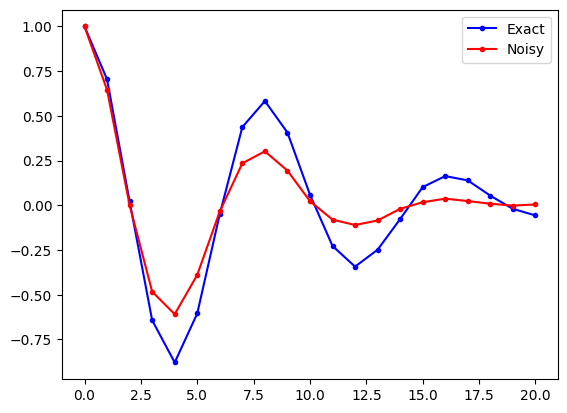

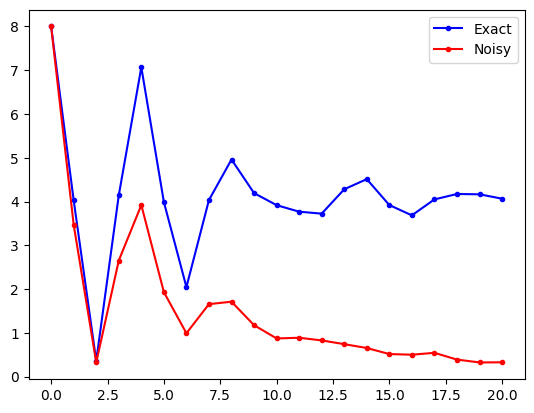

In [ ]:
plt.plot(sim_exp,'.-', color='blue', label='Exact')
plt.plot(sim_exp_noisy,'.-', color='orange', label='Noisy')
plt.legend()

plt.figure()
plt.plot(sim_energy,'.-', color='blue', label='Exact')
plt.plot(sim_energy_noisy,'.-', color='orange', label='Noisy')
plt.legend()